In [1]:
import pandas as pd
import os
import gc
import lightgbm as lgb
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge
from sklearn.decomposition import TruncatedSVD, SparsePCA
from sklearn.preprocessing import MinMaxScaler
from gensim.models import Word2Vec
import math
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

In [18]:
preliminary_a_food = pd.read_csv('./初赛B榜测试集/preliminary_b_food.csv')
preliminary_a_submit_sample = pd.read_csv('./初赛B榜测试集/preliminary_b_submit_sample.csv')
train_food = pd.read_csv('./训练集/train_food.csv')
train_answer = pd.read_csv('./训练集/train_answer.csv')

disease_feature1 = pd.read_csv('./训练集/disease_feature1.csv')
disease_feature2 = pd.read_csv('./训练集/disease_feature2.csv')
disease_feature3 = pd.read_csv('./训练集/disease_feature3.csv')

In [19]:
del preliminary_a_submit_sample['related_prob']

In [20]:
data = pd.concat([train_answer, preliminary_a_submit_sample], axis = 0).reset_index(drop=True)
data.head()

,food_id,disease_id,related
0,food_0,disease_998,0.0
1,food_0,disease_861,0.0
2,food_0,disease_559,0.0
3,food_0,disease_841,0.0
4,food_0,disease_81,0.0


In [21]:
data['food'] = data['food_id'].apply(lambda x : int(x.split('_')[1]))
data['disease'] = data['disease_id'].apply(lambda x : int(x.split('_')[1]))

In [22]:
food = pd.concat([train_food, preliminary_a_food], axis = 0).reset_index(drop=True)
food.head()

,food_id,N_0,N_1,N_2,N_3,N_4,N_5,N_6,N_7,N_8,...,N_202,N_203,N_204,N_205,N_206,N_207,N_208,N_209,N_210,N_211
0,food_0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.02,0.0,NaN,NaN,30.5,92.82,NaN,0.92
1,food_1,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,23.90,0.0,NaN,NaN,0.0,2.41,NaN,3.31
2,food_4,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.12,0.0,NaN,NaN,3.5,15.46,NaN,0.36
3,food_5,NaN,NaN,NaN,0.068,0.0,0.045,0.75,0.314,NaN,...,NaN,NaN,0.89,0.0,NaN,NaN,3.3,86.35,NaN,0.20
4,food_6,NaN,NaN,NaN,0.115,0.0,0.091,0.58,0.508,NaN,...,NaN,NaN,1.13,0.0,0.0,NaN,41.6,93.22,NaN,0.54


In [23]:
cat_list = ['disease']
def stat(df, df_merge, group_by, agg):
    group = df.groupby(group_by).agg(agg)

    columns = []
    for on, methods in agg.items():
        for method in methods:
            columns.append('{}_{}_{}'.format('_'.join(group_by), on, method))
    group.columns = columns
    group.reset_index(inplace=True)
    df_merge = df_merge.merge(group, on=group_by, how='left')

    del (group)
    gc.collect()
    return df_merge

def statis_feat(df_know, df_unknow,cat_list):
    for f in tqdm(cat_list):
        df_unknow = stat(df_know, df_unknow, [f], {'related': ['mean']})

    return df_unknow

df_train = data[~data['related'].isnull()]
df_train = df_train.reset_index(drop=True)
df_test = data[data['related'].isnull()]

df_stas_feat = None
kf = StratifiedKFold(n_splits=5, random_state=2020, shuffle=True)
for train_index, val_index in kf.split(df_train, df_train['related']):
    df_fold_train = df_train.iloc[train_index]
    df_fold_val = df_train.iloc[val_index]

    df_fold_val = statis_feat(df_fold_train, df_fold_val,cat_list)
    df_stas_feat = pd.concat([df_stas_feat, df_fold_val], axis=0)

    del (df_fold_train)
    del (df_fold_val)
    gc.collect()

df_test = statis_feat(df_train, df_test,cat_list)
data = pd.concat([df_stas_feat, df_test], axis=0)
data = data.reset_index(drop=True)

del (df_stas_feat)
del (df_train)
del (df_test)

100%|██████████| 1/1 [00:00<00:00,  8.43it/s]


### 食物特征

In [24]:
# 删除 NAN 较多的特征
(food.isnull().sum().sort_values()/food.shape[0]).describe()

count    213.000000
mean       0.683412
std        0.349754
min        0.000000
25%        0.344828
50%        0.900862
75%        0.993534
max        1.000000
dtype: float64

In [25]:
t = ((food.isnull().sum().sort_values()/food.shape[0])>=0.20)
t

food_id    False
N_188      False
N_209      False
N_74       False
N_14       False
           ...  
N_65        True
N_117       True
N_159       True
N_15        True
N_186       True
Length: 213, dtype: bool

In [26]:
select_food_feat = t[t==False].index.tolist()
len(select_food_feat)

31

### 疾病特征

In [27]:
# 查看重复特征
disease_feat1_cols = disease_feature1.columns.tolist()
disease_feat2_cols = disease_feature2.columns.tolist()
disease_feat3_cols = disease_feature3.columns.tolist()

set(disease_feat1_cols)&set(disease_feat2_cols)&set(disease_feat3_cols) # 100 多个

{'F_1114',
 'F_1190',
 'F_1227',
 'F_1257',
 'F_1260',
 'F_1278',
 'F_1352',
 'F_1368',
 'F_1382',
 'F_1389',
 'F_1395',
 'F_1419',
 'F_1443',
 'F_1460',
 'F_1513',
 'F_1520',
 'F_1594',
 'F_1610',
 'F_1620',
 'F_1628',
 'F_1630',
 'F_1684',
 'F_1709',
 'F_1712',
 'F_1721',
 'F_1776',
 'F_1780',
 'F_1782',
 'F_183',
 'F_1833',
 'F_1838',
 'F_184',
 'F_1849',
 'F_1857',
 'F_187',
 'F_192',
 'F_1981',
 'F_2007',
 'F_2032',
 'F_2058',
 'F_2068',
 'F_2091',
 'F_2094',
 'F_2103',
 'F_2106',
 'F_2118',
 'F_2183',
 'F_2190',
 'F_2196',
 'F_2207',
 'F_2345',
 'F_2398',
 'F_2416',
 'F_2419',
 'F_2428',
 'F_2430',
 'F_2433',
 'F_2504',
 'F_2535',
 'F_2554',
 'F_256',
 'F_265',
 'F_2673',
 'F_269',
 'F_281',
 'F_2843',
 'F_2849',
 'F_2891',
 'F_290',
 'F_2900',
 'F_291',
 'F_2921',
 'F_2982',
 'F_2984',
 'F_3002',
 'F_3034',
 'F_3057',
 'F_3154',
 'F_3159',
 'F_3190',
 'F_3228',
 'F_3272',
 'F_3328',
 'F_3364',
 'F_3398',
 'F_3401',
 'F_3406',
 'F_346',
 'F_3588',
 'F_3623',
 'F_3638',
 'F_3651',

In [28]:
def 降维(feat, ndim=128):
    decom=TruncatedSVD(n_components=ndim, n_iter = 20, random_state=222222)
    decom_x=decom.fit_transform(feat)
    
    return decom_x

In [29]:
# disease 降维
feat1 = 降维(disease_feature1.iloc[:,1:])
feat2 = 降维(disease_feature2.iloc[:,1:])
feat3 = 降维(disease_feature3.iloc[:,1:])

df_feat1 = pd.DataFrame(feat1)
df_feat2 = pd.DataFrame(feat2)
df_feat3 = pd.DataFrame(feat3)

df_feat1.columns = ['disease1_svd_'+str(i) for i in range(df_feat1.shape[1])]
df_feat2.columns = ['disease2_svd_'+str(i) for i in range(df_feat2.shape[1])]
df_feat3.columns = ['disease3_svd_'+str(i) for i in range(df_feat3.shape[1])]

disease_feature1 = disease_feature1[['disease_id']]
disease_feature2 = disease_feature2[['disease_id']]
disease_feature3 = disease_feature3[['disease_id']]

for col in df_feat1.columns:
    disease_feature1[col] = df_feat1[col]
    
for col in df_feat2.columns:
    disease_feature2[col] = df_feat2[col]
    
for col in df_feat3.columns:
    disease_feature3[col] = df_feat3[col]

In [30]:
data = data.merge(food[select_food_feat], on = 'food_id', how = 'left')
data = data.merge(disease_feature1, on = 'disease_id', how = 'left')
data = data.merge(disease_feature2, on = 'disease_id', how = 'left')
data = data.merge(disease_feature3, on = 'disease_id', how = 'left')
data.head()

,food_id,disease_id,related,food,disease,disease_related_mean,N_188,N_209,N_74,N_14,...,disease3_svd_118,disease3_svd_119,disease3_svd_120,disease3_svd_121,disease3_svd_122,disease3_svd_123,disease3_svd_124,disease3_svd_125,disease3_svd_126,disease3_svd_127
0,food_0,disease_861,0.0,0,861,0.003521,0.69,92.82,0.96,32.0,...,0.003703,-0.050574,-0.049544,-0.017477,-0.116327,0.084615,0.072785,0.119895,0.032582,-0.025831
1,food_0,disease_839,0.0,0,839,0.007299,0.69,92.82,0.96,32.0,...,-0.004123,0.011799,-0.012938,-0.005243,0.024514,-0.021790,-0.020413,0.080022,0.056968,-0.013960
2,food_0,disease_50,0.0,0,50,0.018382,0.69,92.82,0.96,32.0,...,0.082681,-0.008134,-0.059040,0.072839,-0.040822,0.002879,-0.031253,0.013910,-0.015712,0.062177
3,food_0,disease_1370,0.0,0,1370,0.214286,0.69,92.82,0.96,32.0,...,-0.113983,0.041052,-0.060705,0.031433,0.020547,0.045441,0.060714,-0.054746,-0.081826,-0.040950
4,food_0,disease_1015,0.0,0,1015,0.202749,0.69,92.82,0.96,32.0,...,-0.035114,-0.033595,-0.015735,-0.043079,0.034971,0.070341,-0.097128,0.082166,-0.014477,0.011394


### 特征交叉

In [31]:
from sklearn.preprocessing import PolynomialFeatures

In [32]:
# 多项式交叉
poly = PolynomialFeatures(degree=3,interaction_only=True)

In [37]:
# 选择交叉的食物特征
t = ((food.isnull().sum().sort_values()/food.shape[0])>=0.10)
poly_cols = t[t==False].index.tolist()

In [38]:
len(poly_cols)

18

In [39]:
# 缺失值填0, 然后交叉
poly_feats = poly.fit_transform(food[poly_cols].fillna(0).iloc[:,1:])
df_poly_feats = pd.DataFrame(poly_feats)
df_poly_feats.columns = [f"food_poly_{i}" for i in range(poly_feats.shape[1])]
df_poly_feats['food_id'] = food.food_id
df_poly_feats

,food_poly_0,food_poly_1,food_poly_2,food_poly_3,food_poly_4,food_poly_5,food_poly_6,food_poly_7,food_poly_8,food_poly_9,...,food_poly_825,food_poly_826,food_poly_827,food_poly_828,food_poly_829,food_poly_830,food_poly_831,food_poly_832,food_poly_833,food_id
0,1.0,0.69,92.82,0.96,32.0,70.0,3.99,2.10,0.126,0.076,...,2.038959,106.4934,0.069476,3.628664,0.619239,3.89988,203.688,34.7598,1.184408,food_0
1,1.0,52.54,2.41,3.73,268.0,471.0,20.96,21.01,1.197,0.077,...,1115.180577,0.0000,13.230279,0.000000,0.000000,1014.91551,0.000,0.0000,0.000000,food_1
2,1.0,0.25,15.46,1.79,62.0,98.0,3.30,79.32,0.125,0.106,...,7.500672,63.4248,0.075007,0.634248,0.479210,3.52512,29.808,22.5216,0.225216,food_4
3,1.0,0.39,86.35,0.39,13.0,23.0,1.40,11.12,0.040,0.030,...,0.468000,60.0000,0.009360,1.200000,0.468000,0.15600,20.000,7.8000,0.156000,food_5
4,1.0,0.12,93.22,2.14,24.0,52.0,2.20,3.88,0.141,0.143,...,2.587788,76.6752,0.099815,2.957472,1.035115,1.42884,42.336,14.8176,0.571536,food_6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459,1.0,0.30,89.79,0.73,33.0,62.0,2.95,6.09,0.102,0.080,...,0.601880,1293.3080,0.019260,41.385856,2.651281,0.52480,1127.680,72.2420,2.311744,food_573
460,1.0,0.18,92.52,0.56,47.0,23.0,1.21,5.37,0.030,0.050,...,0.103500,189.0000,0.001242,2.268000,0.289800,0.06210,113.400,14.4900,0.173880,food_580
461,1.0,0.35,65.20,0.55,3.0,32.0,1.30,31.89,0.076,0.062,...,1.790208,445.1328,0.009448,2.349312,0.914995,0.50616,125.856,49.0176,0.258704,food_585
462,1.0,1.71,89.04,4.61,59.0,97.0,5.71,2.72,0.090,0.018,...,47.585700,0.0000,103.895445,0.000000,0.000000,2021.74920,0.000,0.0000,0.000000,food_586


In [40]:
# 暴力特征交叉
topn = ['N_33', 'N_198', 'N_74','disease','food']
for i in range(len(topn)):
    for j in range(i + 1, len(topn)):
        data[f'{topn[i]}+{topn[j]}'] = data[topn[i]] + data[topn[j]]
        data[f'{topn[i]}-{topn[j]}'] = data[topn[i]] - data[topn[j]]
        data[f'{topn[i]}*{topn[j]}'] = data[topn[i]] * data[topn[j]]
        data[f'{topn[i]}/{topn[j]}'] = data[topn[i]] / (data[topn[j]]+1e-5)

In [41]:
data = data.merge(df_poly_feats, on = 'food_id', how = 'left')
data

,food_id,disease_id,related,food,disease,disease_related_mean,N_188,N_209,N_74,N_14,...,food_poly_824,food_poly_825,food_poly_826,food_poly_827,food_poly_828,food_poly_829,food_poly_830,food_poly_831,food_poly_832,food_poly_833
0,food_0,disease_861,0.0,0,861,0.003521,0.69,92.82,0.96,32.0,...,11.94804,2.038959,106.4934,0.069476,3.628664,0.619239,3.89988,203.688,34.7598,1.184408
1,food_0,disease_839,0.0,0,839,0.007299,0.69,92.82,0.96,32.0,...,11.94804,2.038959,106.4934,0.069476,3.628664,0.619239,3.89988,203.688,34.7598,1.184408
2,food_0,disease_50,0.0,0,50,0.018382,0.69,92.82,0.96,32.0,...,11.94804,2.038959,106.4934,0.069476,3.628664,0.619239,3.89988,203.688,34.7598,1.184408
3,food_0,disease_1370,0.0,0,1370,0.214286,0.69,92.82,0.96,32.0,...,11.94804,2.038959,106.4934,0.069476,3.628664,0.619239,3.89988,203.688,34.7598,1.184408
4,food_0,disease_1015,0.0,0,1015,0.202749,0.69,92.82,0.96,32.0,...,11.94804,2.038959,106.4934,0.069476,3.628664,0.619239,3.89988,203.688,34.7598,1.184408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188843,food_9,disease_1055,NaN,9,1055,0.123563,0.30,91.00,0.50,13.0,...,1.98000,0.342000,7.2000,0.125400,2.640000,0.456000,0.62700,13.200,2.2800,0.836000
188844,food_9,disease_755,NaN,9,755,0.077586,0.30,91.00,0.50,13.0,...,1.98000,0.342000,7.2000,0.125400,2.640000,0.456000,0.62700,13.200,2.2800,0.836000
188845,food_9,disease_1155,NaN,9,1155,0.000000,0.30,91.00,0.50,13.0,...,1.98000,0.342000,7.2000,0.125400,2.640000,0.456000,0.62700,13.200,2.2800,0.836000
188846,food_9,disease_899,NaN,9,899,0.000000,0.30,91.00,0.50,13.0,...,1.98000,0.342000,7.2000,0.125400,2.640000,0.456000,0.62700,13.200,2.2800,0.836000


### 输入特征

In [42]:
drop_cols = ['disease_id', 'food_id', 'related']
for f in data.columns:
    if data[f].nunique() < 2:
        drop_cols.append(f)
        
test_df = data[data["related"].isnull() == True].copy().reset_index(drop=True)
train_df = data[~data["related"].isnull() == True].copy().reset_index(drop=True)

In [43]:
feature_name = [f for f in train_df.columns if f not in drop_cols]
X_train = train_df[feature_name].reset_index(drop=True)
X_test = test_df[feature_name].reset_index(drop=True)
y = train_df['related'].reset_index(drop=True)
print(len(feature_name))
# print(feature_name)

1290


In [44]:
print(test_df.shape)

(47212, 1294)


### 模型训练

In [45]:
train_pred = {}
test_pred = {}

In [46]:
seeds = [222222,2222222]
num_model_seed = len(seeds)
oof = np.zeros(X_train.shape[0])
prediction = np.zeros(X_test.shape[0])
feat_imp_df = pd.DataFrame({'feats': feature_name, 'imp': 0})

def get_para(seed):
    parameters = {
        'learning_rate': 0.01,
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'num_leaves': 63,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'seed': seed,
        'bagging_seed': 1,
        'feature_fraction_seed': 7,
        'min_data_in_leaf': 20,
        'verbose': -1, 
        'n_jobs':8
    }
    return parameters

fold = 5
for model_seed in range(num_model_seed):
    parameters = get_para(seeds[model_seed])
    print(seeds[model_seed],"--------------------------------------------------------------------------------------------")
    oof_cat = np.zeros(X_train.shape[0])
    prediction_cat = np.zeros(X_test.shape[0])
    skf = StratifiedKFold(n_splits=fold, random_state=seeds[model_seed], shuffle=True)
    for index, (train_index, test_index) in enumerate(skf.split(X_train, y)):
        train_x, test_x, train_y, test_y = X_train[feature_name].iloc[train_index], X_train[feature_name].iloc[test_index], y.iloc[train_index], y.iloc[test_index]
        dtrain = lgb.Dataset(train_x, label=train_y)
        dval = lgb.Dataset(test_x, label=test_y)
        lgb_model = lgb.train(
            parameters,
            dtrain,
            num_boost_round=10000,
            valid_sets=[dval],
            early_stopping_rounds=100,
            verbose_eval=300, )
        oof_cat[test_index] += lgb_model.predict(test_x,num_iteration=lgb_model.best_iteration)
        prediction_cat += lgb_model.predict(X_test,num_iteration=lgb_model.best_iteration) / fold
        feat_imp_df['imp'] += lgb_model.feature_importance()

        del train_x
        del test_x
        del train_y
        del test_y
        del lgb_model
    oof += oof_cat / num_model_seed
    prediction += prediction_cat / num_model_seed
gc.collect()

222222 --------------------------------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds
[300]	valid_0's auc: 0.968095
[600]	valid_0's auc: 0.973298
[900]	valid_0's auc: 0.975689
[1200]	valid_0's auc: 0.977045
[1500]	valid_0's auc: 0.977997
[1800]	valid_0's auc: 0.978612
[2100]	valid_0's auc: 0.979153
[2400]	valid_0's auc: 0.979498
[2700]	valid_0's auc: 0.9799
[3000]	valid_0's auc: 0.980104
[3300]	valid_0's auc: 0.980316
[3600]	valid_0's auc: 0.980538
[3900]	valid_0's auc: 0.980725
[4200]	valid_0's auc: 0.980855
[4500]	valid_0's auc: 0.980906
[4800]	valid_0's auc: 0.981041
[5100]	valid_0's auc: 0.981169
Early stopping, best iteration is:
[5123]	valid_0's auc: 0.981186
Training until validation scores don't improve for 100 rounds
[300]	valid_0's auc: 0.968002
[600]	valid_0's auc: 0.973293
[900]	valid_0's auc: 0.975573
[1200]	valid_0's auc: 0.976992
[1500]	valid_0's auc: 0.977928
[1800]	valid_0's auc: 0.978739
[2100

474

In [47]:
train_pred['lgb'] = oof
test_pred['lgb'] = prediction
print("lgb train auc: ", roc_auc_score(y, train_pred['lgb']))

lgb train auc:  0.9810013650327115


In [48]:
# xgb
import xgboost as xgb

seeds = [222222,2222222]
num_model_seed = len(seeds)
oof = np.zeros(X_train.shape[0])
prediction = np.zeros(X_test.shape[0])
# feat_imp_df = pd.DataFrame({'feats': feature_name, 'imp': 0})
def get_para(seed):
    parameters = {
        'booster': 'gbtree',
        'objective': 'binary:logistic',
        'eval_metric': ['logloss','auc'],
        'gamma': 0.1,
        'max_depth': 6, # 树的最大深度
        'alpha': 0.1, # 关于权重的L1正则化项
        'lambda': 0.1,
        'subsample': 0.7,
        'colsample_bytree': 0.5,
        'min_child_weight': 3,
        # 'silent': 0,
        'eta': 0.03, # 学习率
        'nthread': -1,
        'seed': seed,
    }
    return parameters
    
fold = 5
for model_seed in range(num_model_seed):
    parameters = get_para(seeds[model_seed])
    print(seeds[model_seed],"--------------------------------------------------------------------------------------------")
    oof_cat = np.zeros(X_train.shape[0])
    prediction_cat = np.zeros(X_test.shape[0])
    skf = StratifiedKFold(n_splits=fold, random_state=seeds[model_seed], shuffle=True)
    for index, (train_index, test_index) in enumerate(skf.split(X_train, y)):
        train_x, test_x, train_y, test_y = X_train[feature_name].iloc[train_index], X_train[feature_name].iloc[test_index], y.iloc[train_index], y.iloc[test_index]
        xgb_trn_data = xgb.DMatrix(train_x, label=train_y)
        xgb_val_data = xgb.DMatrix(test_x, label=test_y)
        watchlist = [(xgb_trn_data, 'train'), (xgb_val_data, 'valid')]
        clf_xgb = xgb.train(parameters, xgb_trn_data, 10000, watchlist, verbose_eval=100, early_stopping_rounds=300)
        
        oof_cat[test_index] += clf_xgb.predict(xgb.DMatrix(test_x))
        prediction_cat += clf_xgb.predict(xgb.DMatrix(X_test)) / fold
        # feat_imp_df['imp'] += list(clf_xgb.get_fscore().values())
        del train_x
        del test_x
        del train_y
        del test_y
        del clf_xgb
    oof += oof_cat / num_model_seed
    prediction += prediction_cat / num_model_seed
gc.collect()

222222 --------------------------------------------------------------------------------------------
[0]	train-logloss:0.67229	train-auc:0.78325	valid-logloss:0.67233	valid-auc:0.78132
[100]	train-logloss:0.17397	train-auc:0.95927	valid-logloss:0.17975	valid-auc:0.95302
[200]	train-logloss:0.13338	train-auc:0.97191	valid-logloss:0.14326	valid-auc:0.96363
[300]	train-logloss:0.11948	train-auc:0.97714	valid-logloss:0.13335	valid-auc:0.96667
[400]	train-logloss:0.10999	train-auc:0.98136	valid-logloss:0.12810	valid-auc:0.96886
[500]	train-logloss:0.10183	train-auc:0.98480	valid-logloss:0.12399	valid-auc:0.97058
[600]	train-logloss:0.09475	train-auc:0.98765	valid-logloss:0.12099	valid-auc:0.97174
[700]	train-logloss:0.08839	train-auc:0.98997	valid-logloss:0.11827	valid-auc:0.97281
[800]	train-logloss:0.08227	train-auc:0.99196	valid-logloss:0.11562	valid-auc:0.97378
[900]	train-logloss:0.07727	train-auc:0.99347	valid-logloss:0.11391	valid-auc:0.97440
[1000]	train-logloss:0.07238	train-auc:0.9

125

In [49]:
train_pred['xgb'] = oof
test_pred['xgb'] = prediction
print("lgb train auc: ", roc_auc_score(y, train_pred['xgb']))

lgb train auc:  0.9775950834428532


In [65]:
train_pred['xgb_lgb'] = (0.7*train_pred['lgb'] + 0.3*train_pred['xgb'])
test_pred['xgb_lgb'] = (0.7*test_pred['lgb'] + 0.3*test_pred['xgb'])
print("lgb train auc: ", roc_auc_score(y, train_pred['xgb_lgb']))

lgb train auc:  0.9804065112541743


In [79]:
len(train_pred['lgb'])

141636

In [80]:
# LR 融合
from sklearn.linear_model import LinearRegression

lrg = LinearRegression()
train_prob = pd.DataFrame()
train_prob['lgb'] = train_pred['lgb']
train_prob['xgb'] = train_pred['xgb']
train_prob['label'] = y

test_prob = pd.DataFrame()
test_prob['lgb'] = test_pred['lgb']
test_prob['xgb'] = test_pred['xgb']
lrg.fit(train_prob[['lgb','xgb']], train_prob.label)
prob_y = lrg.predict(test_prob)

In [81]:
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.1,0.9,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (train_pred['xgb_lgb'].reshape((-1)) > threshold).astype('int')
    m = f1_score(y.values.reshape((-1)), preds, average='binary')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.20, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.30, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 

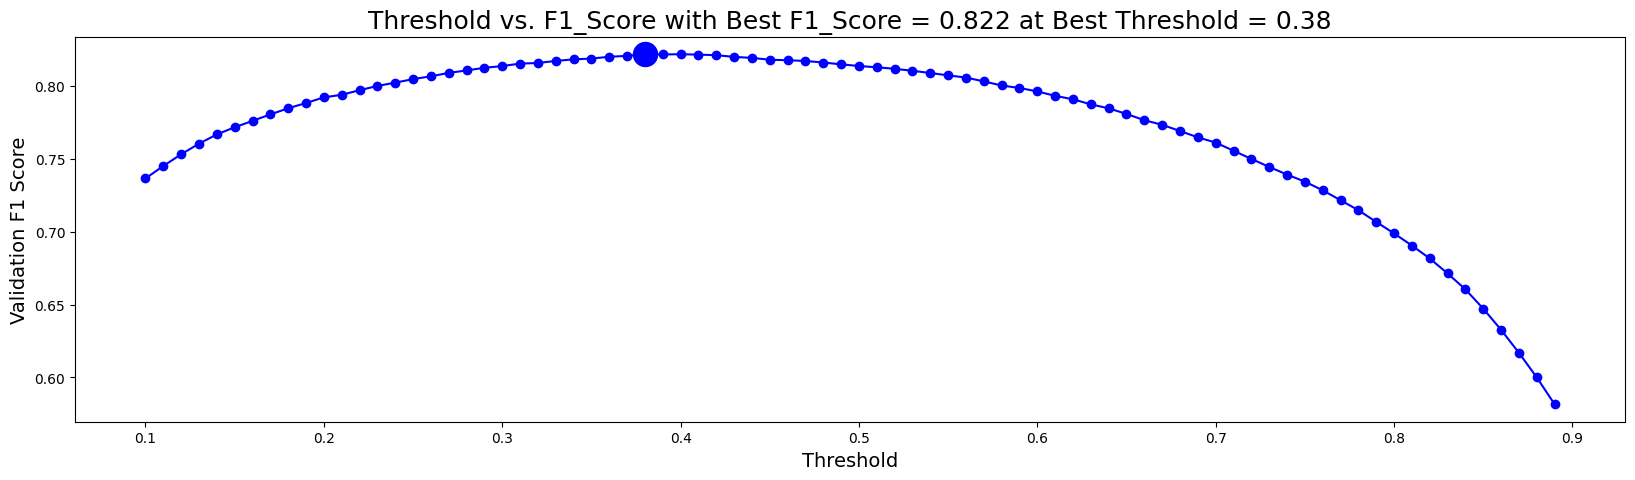

In [70]:
import matplotlib.pyplot as plt

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [67]:
auc = roc_auc_score(y, train_pred['xgb_lgb'])
f1 = best_score
print((auc + f1) / 2)

0.9009756951601839


In [71]:
prediction = prob_y

In [82]:
label=[1 if x >= 0.20+0.30 else 0 for x in prediction+0.30]
np.sum(label)

4555

In [83]:
preliminary_a_submit_sample['related_prob'] = prediction+0.30

In [84]:
preliminary_a_submit_sample.to_csv('submit_0321_lr.csv', index=False)

In [88]:
train_prob.columns = ['lgb_1','xgb_1','label_1']
train_prob.to_csv('./train_prob_1.csv',index=False)
test_prob.columns = ['lgb_1','xgb_1']
test_prob.to_csv('./test_prob_1.csv',index=False)